# IBD Survey Data Import, Munging and Initial Exploration

In [153]:
from IPython.display import display_html
import numpy as np
import pandas as pd
import scipy
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns


# create the database and tables, and import data
# %run db_builder.py

query = """SELECT uf.user_id, foods.name, uf.prep_id, uf.rating, uf.unknown
FROM users_to_foods uf, foods
WHERE uf.food_id = foods.id"""

# import data
conn = sqlite3.connect('food_db.db')
df = pd.read_sql(query, conn)

# default formatting for values
# pd.options.display.float_format = '{:,.0f}'.format
# pd.reset_option("^display")

def display_side_by_side(*args):
    # displays dfs side-by-side
    html_str=''
    for df in args:
        try:
            html_str+=df.to_html()
        except AttributeError:
            df2= pd.DataFrame(df)
            html_str+=df2.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding: 10px"'),raw=True)  

# confirm the number or rows (questions presented to users, in total) 
print('Number of questions presented to users: {0}'.format(df.shape[0]))

Number of questions presented to users: 151899


With the data in a dataframe, we can pivot the data so each row represents a person's survey answers and we can see the number of participants. However, pivoting initially fails with coulmn set to 'name', since two names weren't unique. 'Pumpkin' was used for both pumpkin as a vegetable and pumpkin seed. 'Squash' was similarly used to reflect both the vegetable and the drink. Manually adjusted the names (to 'Pumpkin seed' and 'Squash (drink)', respectively) to prevent confusion and allow the intended pivot without accidentally aggregating answers to very different survey questions yields:

In [154]:
print(df.columns)
df_pivot = df.pivot(index='user_id', columns='name')
df_pivot.tail()

Index(['user_id', 'name', 'prep_id', 'rating', 'unknown'], dtype='object')


prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3547             NaN    NaN         0.0     0.0   NaN         NaN     NaN   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3547           NaN       NaN       NaN       ...              NaN        NaN   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3547      0.0     NaN              NaN         NaN        NaN   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3547                 NaN          NaN             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Some NaNs already appear in the table, which most likely means that not all food questions were asked for all surveys. My supposition is that there were multiple iterations of the survey all stored in the data table without a column to label the survey number. Let's see how many surveys there were and what the size of each survey was:

In [155]:
q_count = {}
for i in df_pivot.isnull().sum(axis=1).sort_values(ascending=False):
    key = str(int((df_pivot.shape[1] - i)/3)) + '-question'  # divide by 3 to reflect the # of hierarchically indexed columns
    if key in q_count:
        q_count[key] += 1
    else:
        q_count[key] = 1

for k, v in q_count.items():
    print (k,'survey count: ', v)

40-question survey count:  29
61-question survey count:  14
80-question survey count:  24
125-question survey count:  8
164-question survey count:  16
199-question survey count:  8
249-question survey count:  1
250-question survey count:  570


We may still be able to use all of the data from the various iterations of the survey for analysis not sensitive to missing values, but for now we will limit our core data set to only the latest 250-question version of the exam, which leaves ~85% of the initial surveys (570/670).

In [156]:
df_old_surveys = df_pivot.loc[pd.isnull(df_pivot).any(1),:]
print('Confirmed number of old surveys, which are excluded (and saved for later): {0}'.format(df_old_surveys.shape[0]))
df_new_surveys = df_pivot.dropna()
print('Confirmed number of new surveys, which are included: {0}'.format(df_new_surveys.shape[0]))
df_new_surveys.tail()

Confirmed number of old surveys, which are excluded (and saved for later): 100
Confirmed number of new surveys, which are included: 570


prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3544             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3544           0.0       0.0       0.0       ...              0.0        0.0   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3544      0.0     0.0              0.0         0.0        0.0   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3544                 0.0          0.0             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Surveys appear to have values of 0 for both a filled in answer of never being able to eat a food, and when the participant decided not to answer the question. We can remove questions that participants decided not to answer based on a 1 (True) value for the "unknown" column. ((This will result in NaN values in our dataframe.))

In [157]:
df_unpivot = df_new_surveys.stack().reset_index()
df_answered = df_unpivot[df_unpivot.unknown != 1 ]
df_answered_pivot = df_answered.pivot(index='user_id', columns='name', values='rating')
print('{0} questions weren\'t answered.'.format(int(df_answered_pivot.isnull().sum().sum())))
df_answered_pivot.tail()

53429 questions weren't answered.


name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
user_id,,,,,,,,,,,,,,,,,,,,,
3544,NaN,10.0,NaN,10.0,4.0,0.0,5.0,10.0,10.0,NaN,...,10.0,10.0,2.0,9.0,2.0,1.0,2.0,1.0,0.0,10.0
3558,6.0,6.0,10.0,8.0,4.0,4.0,4.0,9.0,7.0,6.0,...,4.0,6.0,1.0,2.0,3.0,3.0,6.0,3.0,3.0,3.0
3559,NaN,10.0,NaN,NaN,10.0,0.0,NaN,7.0,7.0,4.0,...,NaN,9.0,NaN,NaN,5.0,6.0,NaN,6.0,7.0,9.0
3563,NaN,7.0,7.0,NaN,6.0,NaN,NaN,NaN,6.0,NaN,...,NaN,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3566,NaN,NaN,NaN,NaN,5.0,NaN,6.0,NaN,NaN,NaN,...,NaN,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


That's a really high number of questions that weren't answered. Let's dig into which questions went unanswered the most:

In [158]:
# counts of unanswered question by food, sorted most to least
# can compare the % answered from the new and old surveys to help improve the survey responses
possible = df_answered_pivot.shape[0]
unanswered_count = df_answered_pivot.isnull().sum().sort_values(ascending=False)
unanswered_percent = unanswered_count.divide(possible)*100
unanswered = pd.DataFrame({'unanswered_count': unanswered_count, 'unanswered_percent': unanswered_percent})
unanswered['unanswered_percent'] = unanswered['unanswered_percent'].map('{:,.2f}%'.format)

display_side_by_side(unanswered.head(10), unanswered.tail(10).sort_values('unanswered_percent'))

,unanswered_count,unanswered_percent
name,,
Goose Egg,486,85.26%
Quail Egg,470,82.46%
Rabbit,462,81.05%
Goose,445,78.07%
Herring,442,77.54%
Veal,439,77.02%
Hazelnut Milk,437,76.67%
Rice Milk,436,76.49%
Oysters,434,76.14%


The least answered survey questions (left table above) seem to be less commonly eaten foods, such as goose eggs and quail eggs, which makes sense - users can't answer if they can eat a food if they haven't tried it before. Conversely, and supporting that conclusion, the most answered survey questions (right table above) all seem to be more common foods (however, of note, there is no question that was answered by everyone). It also makes sense in the context of the number of question responses on surveys, with the average person only answering 156/250 (62%) of the questions (and only 19 answering all 250):

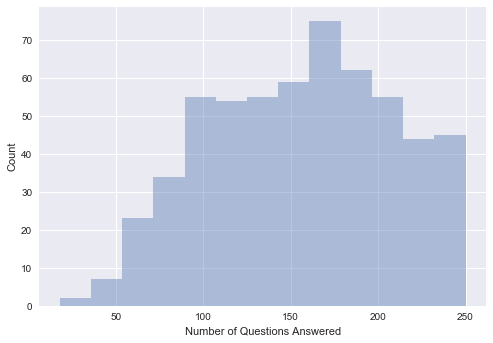

count    570.00
mean     156.26
std       52.75
min       18.00
25%      118.00
50%      158.50
75%      197.00
max      250.00
dtype: object

In [159]:
num_answers_per_person = df_answered_pivot.count(axis=1)

# distribution of number of answers per survey
sns.distplot(num_answers_per_person.dropna(), kde=False)
plt.xlabel('Number of Questions Answered')
plt.ylabel('Count')
plt.show()

num_answers_per_person.describe().apply('{:,.2f}'.format)

So the remaining data points seem to accurately reflect our usable data set, but now the quality/usability of that data is called into doubt. Before we clean up the data further (decide how to handle NaNs), we need to assess what type of data we're working with (measurement scale), and as a result, the available/appropriate tests we'll be using the data for.

Determining whether our survey results most appropriately reflect interval data (as it was collected) or [discrete] ordinal data (categorical data, where the values don't necessarily have equal "distance") is somewhat challenging in this case, and extremely important.  If we determine that our data is ordinal, parameters such as mean and standard deviation will likely be invalid, and any parametric analyses (generally considered to have more statistical power) based on the normal distribution will be impossible. Rather, rank, median, and range and associated tests (such as classification) will be the extent of our toolkit. The “intervalness” of the data is an attribute of the data, not of the labels.

The primary distinguishing factor will be whether the "distance" between responses is equal and meaningful. The edge cases in specific will be the determining factor: is the distance between 0 and 1 (never eat and very, very rarely eat) the same as 1 to 2 (very, very rarely eat to very rarely eat)? Unfortunately it seems logical that those distances are not the same (although survey partcipants may have mentally been assuming such equal increments in attempting to place the scale). You can eat "infinitely" more of a food at 1 than 0 (i.e. how can you even measure the distance from always to anything less than always?), bounded only by the normal quantities of food people can/want to eat. As a result of the fact that distances are inherently unequal, it would seem that the data should be treated as ordinal (and for testing purposes, therefore, largely categorical).

However the answer to this question is actually highly controvetial in the field of statistics, with Likert survey results (usually five or seven options, presented as variations on 'Always,' 'Sometimes,' 'Never') being the primary focus of that debate/research. The scope of the debate is beyond the pervue of this report, but the ultimate "answer" to the debate is that in at least some cases (particularly when we have data collected from a label-less, continuous, sliding scale, as with our survey data; see sample image below), interval-type parametric analysis is robust enough with respect to violations of its core assumptions that it can appropriately be run on Likert-style survey data. As a result, we will cautiously attempt to analyze the data assuming interval measurement in some cases (understanding the limitations of mean and variance as descriptive statistics).

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3886444/
* https://www.scribd.com/document/344028976/Likert-scales-levels-of-measurement-and-the-laws-of-statistics-pdf
* https://statisticscafe.blogspot.it/2011/05/how-to-use-likert-scale-in-statistical.html?m=1
* https://stats.stackexchange.com/questions/175848/parametric-tests-and-likert-scales-ordinal-data-two-different-views

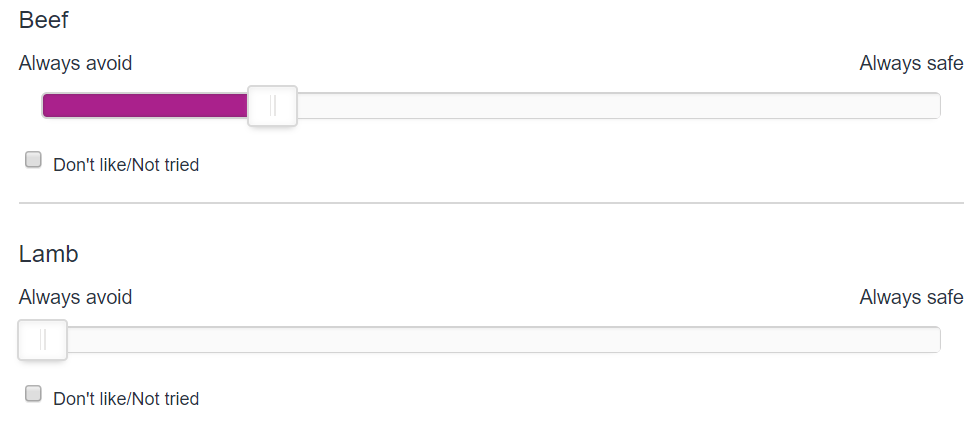

That said, and even assuming we have interval data, the facts that 1) the data was collected on a integer basis (as opposed to continuous) and 2) the probability distibutions of each of the food's responses are non-normal (and not normalizable without material and potentially biasing transformations) potentially severely limit the ability to utilize the more statistically powerful tests we'd hoped to be able to use anyway (e.g. regressions). See below for some of the supporting statistics:

In [160]:
question_answer_summary = df_answered_pivot.describe()
question_answer_summary.applymap('{:,.2f}'.format)

name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
count,180.00,448.00,229.00,161.00,550.00,497.00,362.00,198.00,395.00,306.00,...,327.00,453.00,516.00,295.00,417.00,414.00,360.00,426.00,433.00,495.00
mean,3.23,4.08,6.99,4.97,5.39,4.68,4.24,3.71,5.80,2.73,...,5.17,6.28,4.02,2.25,3.43,3.37,2.96,3.29,3.59,5.80
std,4.21,3.94,3.85,4.37,3.84,4.02,3.84,3.98,3.88,3.53,...,4.05,3.86,3.61,3.48,3.67,3.66,3.62,3.57,3.63,3.97
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,5.00,0.00,2.00,0.00,0.00,0.00,2.00,0.00,...,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,0.00,4.00,10.00,5.00,5.00,5.00,4.00,2.00,6.00,1.00,...,5.00,7.00,4.00,0.00,2.00,2.00,1.00,2.00,3.00,6.00
75%,8.00,8.00,10.00,10.00,10.00,10.00,7.75,7.00,10.00,5.00,...,10.00,10.00,6.00,5.00,6.00,6.00,5.00,6.00,6.00,10.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00


In [161]:
# run tests for normality
scipy.stats.normaltest(df_answered_pivot, nan_policy='omit')
# ALSO use scipy.stats.shapiro shapiro-wilk test
# add both w/ p-val to description df
# If the p-val is very small, it means it is unlikely that the data came from a normal distribution. Use 5%.

NormaltestResult(statistic=masked_array(data = [106.81400880813243 -- 43.69476870920097 -- -- -- 1231.4822633458443
 205.29475833669426 -- 42.59282470953727 -- 385.0925223786179
 19074.341656821412 79.75937551748495 49.368912222701766 121.49347478009904
 415.3803011096851 86.63578389644313 163.24753488841608 63.81532683860141
 147.90436624540024 100.8818372534133 984.665101202696 63.40748039639519 --
 2040.1903639697277 -- 90.04867432404691 152.75463791206346
 128.89587838611016 -- -- 199.53184576623937 44.739874011455996
 230.91738504877478 -- -- 294.0576624104485 500.8287699847974
 75.18613499086861 4422.601423648415 -- -- 108.9556520026662 --
 1025.5595853089148 1061.3904424355471 -- -- 45.273977501004694
 38.85486239652403 263.63023943244974 83.8434433594168 3332.900980288191 --
 -- -- -- 51.010191986620086 -- 275.12847481561715 -- 109.00673262774507
 203.5243720282529 690.7309178006759 264.03106648979116 30083.121559464398
 58.23495793850375 247.27406437532235 -- -- -- -- 166.4674

Though as long as we're looking at the data, there are a couple observations we can fairly make now: at first glance it seems like there are no universally tolerated/untolerated foods:

In [162]:
print('There are no foods that everyone could tolerate.' if question_answer_summary.loc['min'].max() == 0 else 'There ARE foods that everyone could tolerate.')
print('There are no foods that noone could tolerate.' if question_answer_summary.loc['max'].min() == 10 else 'There ARE foods that noone could tolerate.')

There are no foods that everyone could tolerate.
There are no foods that noone could tolerate.


Lastly, and now that we've determined our data will be "cautiously"  interval (but otherwise ordinal), we can drop missing data from our data set (as most methods of analysis we'll be able to run have difficulty with missing data). However, given the sparcity of our data, that's not such an easy task. We've already established that not a single food had an answer given by every participant, and that only 19 people answered all 250 questions. What we're left with is a multi-objective optimization problem.

Luckily, all our possibilities are all "optimal" solutions, so we just need to identify a reasonable set of the possible choices, plot them (known as a 'Pareto Front' or a 'Tradeoff Curve'), and then use our judgement to select the appropriate starting place.

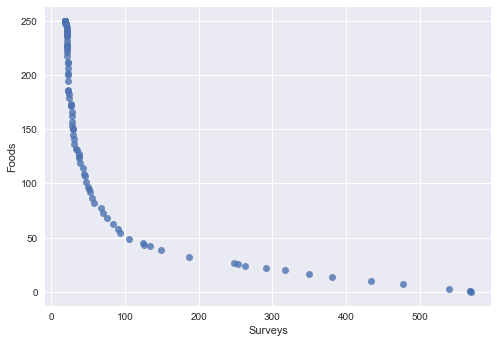

,Missing Survey Percentage,Surveys,Foods
39,0.39,22,212
42,0.42,23,202
49,0.49,26,173
52,0.52,28,166
59,0.59,31,141
61,0.61,34,132
63,0.63,37,127
66,0.66,39,119
67,0.67,43,114
68,0.68,44,109


In [163]:
l=[]
for missing_survey_perc in np.linspace(0.00, 1.00, num=101):
    df_before_preprocessing = df_answered_pivot.dropna(thresh=missing_survey_perc*len(df_answered_pivot), axis=1)
    l.append([missing_survey_perc, df_before_preprocessing.dropna().shape[0], df_before_preprocessing.dropna().shape[1]])

pareto = pd.DataFrame(l, columns=['Missing Survey Percentage', 'Surveys', 'Foods'])
sns.regplot(x=pareto['Surveys'], y=pareto['Foods'], fit_reg=False)
plt.show()

# plot summary of table:
pareto.loc[(pareto['Foods'].diff() < -3) & (pareto['Surveys'].diff() > 0)]

Deciding is somewhat arbitrary, but given our already limited dataset, and that we want our sample size to be as large as possible for the sake of statistical power (especially considering our data scale), the three seemingly most useful options are dropping 87% 88%, or 95% of the data (see table above for associated numbers of surveys and foods). We can swap out for a different choice easily enough later, but I will start with 88% (where I have complete data for 248 survey results for 27 foods):

In [164]:
df_before_preprocessing = df_answered_pivot.dropna(thresh=0.88*len(df_answered_pivot), axis=1).dropna(axis=0)
df_before_preprocessing

name,Apple,Bananas,Beef,Broccoli,Butter,Carrots,Cheese - Hard,Chicken,Chicken Egg,Chocolate - Milk,...,Orange,Orange Juice (without bits),Peas,"Potatoes, White","Rice, White",Strawberries,Sugar,Tap Water,Tomatoes,Wheat
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,10.0,2.0,10.0,2.0,10.0,2.0,6.0,0.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,9.0,10.0,7.0,9.0,0.0,9.0,0.0,10.0,10.0,0.0,...,5.0,6.0,6.0,2.0,10.0,9.0,8.0,5.0,0.0,0.0
12,4.0,2.0,1.0,0.0,5.0,0.0,2.0,4.0,10.0,2.0,...,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0
13,0.0,0.0,5.0,0.0,5.0,0.0,2.0,10.0,0.0,5.0,...,0.0,5.0,0.0,5.0,5.0,0.0,5.0,10.0,0.0,0.0
24,2.0,10.0,7.0,9.0,9.0,10.0,3.0,10.0,9.0,10.0,...,0.0,0.0,1.0,9.0,1.0,10.0,10.0,10.0,2.0,2.0
29,8.0,10.0,10.0,0.0,5.0,10.0,5.0,10.0,8.0,8.0,...,5.0,6.0,9.0,10.0,10.0,8.0,10.0,10.0,4.0,5.0
30,3.0,9.0,6.0,1.0,10.0,9.0,2.0,9.0,9.0,2.0,...,0.0,10.0,1.0,10.0,9.0,3.0,2.0,10.0,1.0,0.0
59,10.0,10.0,3.0,7.0,10.0,10.0,8.0,10.0,8.0,4.0,...,3.0,5.0,3.0,10.0,5.0,3.0,5.0,10.0,10.0,0.0
88,3.0,8.0,10.0,6.0,6.0,8.0,2.0,10.0,10.0,2.0,...,3.0,6.0,8.0,10.0,10.0,10.0,8.0,10.0,9.0,6.0


With that, we have a fully scrubbed data set to work with. Our one last step is to preprocess the data for our planned analysis.

# IBD Survey Data Preprocessing

While our data is already scaled to a common range, we will employ the MinMaxScaler (which in our case, given that every food has a 0 minimum and 10 maximum effectively just divides by 10 for our data), for a couple of reasons:
1. Some of our algorithms will run more quickly as a result of scaling and
2. Having all values between zero and one gives us a nice, easy option to convert the sometimes data (1-9) to either 0 or 1 via rounding, so we can look at foods on a simple can/can't eat basis.

In [165]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_answered_pivot_scaled = min_max_scaler.fit_transform(df_before_preprocessing)

df_final_27foods = pd.DataFrame(df_answered_pivot_scaled, columns=df_before_preprocessing.columns)
print(df_final_27foods)


# also plot histograms for all foods; add normal distribution line

#df_answered_pivot.plot.hist(layout=(125,2))
#plt.show()

# f, axes = plt.subplots(125,2, figsize=(7,7), sharex=True)
# sns.distplot(df_answered_pivot.dropna(), kde=True, color='b', ax=axes)
# plt.show()

# for column in df_answered_pivot.columns:
#     print(type(column), column)
#     sns.distplot(df_answered_pivot[column].dropna())
#     plt.show()

name  Apple  Bananas  Beef  Broccoli  Butter  Carrots  Cheese - Hard  Chicken  \
0       0.5      1.0   0.2       1.0     0.2      1.0            0.2      0.6   
1       0.9      1.0   0.7       0.9     0.0      0.9            0.0      1.0   
2       0.4      0.2   0.1       0.0     0.5      0.0            0.2      0.4   
3       0.0      0.0   0.5       0.0     0.5      0.0            0.2      1.0   
4       0.2      1.0   0.7       0.9     0.9      1.0            0.3      1.0   
5       0.8      1.0   1.0       0.0     0.5      1.0            0.5      1.0   
6       0.3      0.9   0.6       0.1     1.0      0.9            0.2      0.9   
7       1.0      1.0   0.3       0.7     1.0      1.0            0.8      1.0   
8       0.3      0.8   1.0       0.6     0.6      0.8            0.2      1.0   
9       0.0      1.0   0.0       0.0     0.0      1.0            0.0      0.0   
10      1.0      1.0   0.4       1.0     1.0      1.0            0.0      1.0   
11      0.0      0.0   0.0  

# IBD Survey Analysis with Machine Learning

Choosing the right ML techniques:
  * Table: https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-choice
  * InfoGraphic: https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-cheat-sheet
  * InfoGraphic: http://scikit-learn.org/stable/tutorial/machine_learning_map/
  * http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/
  * http://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml06.pdf
  * https://blogs.sas.com/content/subconsciousmusings/2017/04/12/machine-learning-algorithm-use/
  * http://www.datasciencecentral.com/profiles/blogs/want-to-know-how-to-choose-machine-learning-algorithm

ML gone wrong:
  * http://ml.posthaven.com/machine-learning-done-wrong
 
Apriori Algorithm:
  * Unsupervised algorithm (also a type of association analysis) for finding things that are commonly found together. Advantages over clustering, regression, NN, SVM, etc. is that it’s intuitive, math-light, and doesn’t require a lot of data scrubbing/understanding:
  * https://pypi.python.org/pypi/apyori/1.1.1
  * http://pbpython.com/market-basket-analysis.html

IDEA: Create table of mann-Whitney tests for pairwise comparisons between all features (better than t-test).

Begin with unsupervised machine learning techniques, to see what the data reveals. 
* First, use pairwise k-mode clustering using Hamming distance
  * https://www.quora.com/Why-does-K-means-clustering-perform-poorly-on-categorical-data-The-weakness-of-the-K-means-method-is-that-it-is-applicable-only-when-the-mean-is-defined-one-needs-to-specify-K-in-advance-and-it-is-unable-to-handle-noisy-data-and-outliers
  * https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data
* Then continue k-mean clustering between elements from related data (can do this for all 250 foods?)
  * Take related foods and see what nutrients they have in common. Can use continuous ratio data; identify nutrient and nutrient level triggers.
 
Supervised methods:
* Ordinal regression: 
 * https://pythonhosted.org/mord/ 
 * http://fa.bianp.net/blog/2013/logistic-ordinal-regression/
 * https://github.com/statsmodels/statsmodels/issues/807
 * http://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf
* random forest; what it says about feature importance
  * https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree

In [166]:
from apyori import apriori

transactions = np.floor(df_final_27foods)  # Only count 1 as being able to eat; everything else is can't eat for now.
transactions = pd.DataFrame(transactions, columns=df_final_27foods.columns)
transactions = transactions.apply(lambda x: x.astype(object).replace(1, x.name))
# print(transactions)

# results = list(apriori(transactions, min_support=0.4, min_confidence=0, min_lift=1, max_length=None))
# for result in results:
#     print(result)